# Notebook para la pregunta 4.4 sobre el reconocimiento de escenas con Redes Convolucionales Neuronales


# 1.Preparación del entorno de trabajo como en los notebooks anteriores

In [ ]:
#%%capture
#%tensorflow_version 2.x
!pip install tensorflow==2.3.0
import tensorflow as tf
import os, subprocess
!python --version                     # mostrar version de python
print('Tensorflow ' + tf.__version__) # mostrar version tensorflow

     |████████████████████████████████| 320.4 MB 51 kB/s 
     |████████████████████████████████| 2.9 MB 22.0 MB/s 
     |████████████████████████████████| 459 kB 16.2 MB/s 
     |████████████████████████████████| 20.1 MB 39.5 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.7.0
    Uninstalling tensorflow-2.7.0:


Python 3.7.12
Tensorflow 2.3.0


# 2.Creación y almacenamiento de los datos

In [ ]:
import os, subprocess

# Montar Google Drive y crear carpetas
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

work_dir = '/content/work_dir'                    # directorio de trabajo en local (mas rapido)
dwld_dir = '/content/gdrive/My Drive/dwld_dir'    # directorio de descarga en Google drive personal
subprocess.call(["mkdir","-p",work_dir])          # crear directorio para trabajo
subprocess.call(["mkdir","-p",dwld_dir+'/dataset/'])  # crear directorio para dataset

os.chdir(dwld_dir+'/dataset/')                        # posicionarse en el directorio
# Descargar dataset scenes15 si no esta disponible
if os.path.isfile('./dataset_scenes15.zip') == False: 
  !wget http://www-vpu.eps.uam.es/~jcs/tsv/dataset_scenes15.zip 
  
# Copiar el dataset al directorio local (mayor velocidad de lectura que en Gdrive)
!cp /content/gdrive/My\ Drive/dwld_dir/dataset/dataset_scenes15.zip /content/work_dir/

os.chdir(work_dir)                        # posicionarse en el directorio
if os.path.isdir('./scenes15') == False: 
  !unzip -o -q dataset_scenes15.zip -d .

print('El dataset se encuentra descargado en el directorio {} \ny descomprimido en el directorio {} (usado para lectura de datos)'.format(dwld_dir, work_dir))

Mounted at /content/gdrive
El dataset se encuentra descargado en el directorio /content/gdrive/My Drive/dwld_dir 
y descomprimido en el directorio /content/work_dir (usado para lectura de datos)


# 3.Seleccionamos Hardware como en ejemplos previos

In [ ]:
import tensorflow as tf
import time

print("Num CPUs disponibles: ", len(tf.config.experimental.list_physical_devices('CPU')))
print("Num GPUs disponibles: ", len(tf.config.experimental.list_physical_devices('GPU')))

time1 = time.time() # medida de tiempo

# ejecutar en CPU
with tf.device('/CPU:0'):
  random_image_cpu = tf.random.normal((100, 100, 100, 3))
  net_cpu = tf.keras.layers.Conv2D(128, 7)(random_image_cpu)

time2 = time.time() # medida de tiempo

# ejecutar en GPU
with tf.device('/device:GPU:0'):
  random_image_cpu = tf.random.normal((100, 100, 100, 3))
  net_cpu = tf.keras.layers.Conv2D(128, 7)(random_image_cpu)

time3 = time.time() # medida de tiempo
print('Tiempo ejecución CPU {} secs y GPU {} secs' .format(time2-time1, time3-time2))
print('Ejecute varias veces este bloque de código pues la primera vez no observará diferencias debido a que se deben inicializar los registros para la CPU y GPU')

Num CPUs disponibles:  1
Num GPUs disponibles:  1
Tiempo ejecución CPU 0.9114224910736084 secs y GPU 0.01063084602355957 secs
Ejecute varias veces este bloque de código pues la primera vez no observará diferencias debido a que se deben inicializar los registros para la CPU y GPU


# 4.Crear iterador para los datos del dataset, definición del modelo, optimización de parámetros, entrenamiento y clasificación

In [ ]:
import tensorflow as tf
import pathlib
import numpy as np
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optimizers
import matplotlib.pyplot as plt

datagen1 = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.20, 
    horizontal_flip=True)

datagen2 = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.20,
    brightness_range=(0.2, 0.8))

datagen3 = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.20, 
    zoom_range=0.2)


datagen4 = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.20, 
    horizontal_flip=True,
    zoom_range=0.2)


accs = [] 
val_accs = []
losses = []
val_losses = []

datagens = [datagen1, datagen2, datagen3, datagen4]

for datagen in datagens:
  dataset_dir = pathlib.Path(work_dir + '/scenes15/')

  # Obtener etiquetas de clase y numero de clases
  CLASS_NAMES = np.array([item.name for item in dataset_dir.glob('*')]) #clases son subdirectorios de '/train/'
  NUM_CLASSES = len(CLASS_NAMES) # numero total de clases
  

  # Crear ImageDataGenerator convirtiendo de uint8 a float32 en el rango [0,1].
  img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.20)

  # Obtenemos un iterador sobre los datos de entrenamiento del dataset
  # aplicando el ImageDataGenerator creado anteriormente
  BATCH_SIZE = 32 # numero de elementos procesados conjuntamente en cada iteracion
  IMG_HEIGHT = 32
  IMG_WIDTH = 32
  IMG_CHANNELS = 3

  train_data_gen = img_gen.flow_from_directory(directory=str(dataset_dir),
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode='rgb',                                                     
                                            classes = list(CLASS_NAMES),
                                            class_mode='categorical',
                                            batch_size=BATCH_SIZE, 
                                            subset="training",                                         
                                            shuffle=True,
                                            seed=0)

  test_data_gen = img_gen.flow_from_directory(directory=str(dataset_dir),
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode='rgb',                                                     
                                            classes = list(CLASS_NAMES),
                                            class_mode='categorical',
                                            batch_size=BATCH_SIZE,
                                            subset="validation",
                                            shuffle=True,
                                            seed=0)
  
  # definir modelo de red
  model = models.Sequential()

  # incluir capa convolucional C1
  model.add(layers.Conv2D(filters=6, 
                          kernel_size=(3, 3), 
                          strides = (1,1),
                          padding = 'valid',
                          activation='relu', 
                          input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)))

  # incluir average pooling S2
  model.add(layers.AveragePooling2D())

  # incluir capa convolucional C3
  model.add(layers.Conv2D(filters=16, 
                          kernel_size=(3, 3),
                          strides = (1,1),
                          padding = 'valid', 
                          activation='relu'))

  # incluir average pooling S4
  model.add(layers.AveragePooling2D())

  # convertir el volumen de datos en vector fila para conectarlo con capa FC
  model.add(layers.Flatten())

  # incluir fully convolutional F5
  model.add(layers.Dense(units=120, activation='relu'))

  # incluir fully convolutional F6
  model.add(layers.Dense(units=84, activation='relu'))

  # incluir salida OUTPUT
  model.add(layers.Dense(units=NUM_CLASSES, activation = 'softmax'))

  LEARNING_RATE = 0.01 # factor de aprendizaje
  model.compile(optimizer=optimizers.SGD(lr=LEARNING_RATE),            
            loss='categorical_crossentropy',            
            metrics=['accuracy'])
  
  EPOCHS = 25 # numero de epocas para entrenamiento

  #si tiene problemas al ejecutar con la GPU, 
  # descomente la siguiente linea para utilizar la CPU
  # y comente la linea que selecciona la GPU
  #with tf.device('/CPU:0'):
  with tf.device('/GPU:0'):
    history = model.fit_generator(
        generator=train_data_gen,          
        steps_per_epoch=train_data_gen.n // BATCH_SIZE,      
        validation_data=test_data_gen,
        validation_steps=test_data_gen.n // BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1     
    )  

  #si tiene problemas al ejecutar con la GPU, 
  # descomente la siguiente linea para utilizar la CPU
  # y comente la linea que selecciona la GPU
  #with tf.device('/CPU:0'):
  with tf.device('/GPU:0'):
    test_loss, test_acc = model.evaluate_generator(generator=test_data_gen, 
                                                  steps = test_data_gen.n // BATCH_SIZE, 
                                                  verbose=1)
  accs.append(history.history['accuracy']) 
  val_accs.append(history.history['val_accuracy'])
  losses.append(history.history['loss'])
  val_losses.append(history.history['val_loss'])

Found 3592 images belonging to 15 classes.
Found 893 images belonging to 15 classes.
Epoch 1/25
112/112 [==============================] - 6s 50ms/step - loss: 2.7053 - accuracy: 0.0764 - val_loss: 2.6983 - val_accuracy: 0.0995
Epoch 2/25
112/112 [==============================] - 5s 42ms/step - loss: 2.6946 - accuracy: 0.0924 - val_loss: 2.6893 - val_accuracy: 0.1053
Epoch 3/25
112/112 [==============================] - 5s 41ms/step - loss: 2.6855 - accuracy: 0.0986 - val_loss: 2.6789 - val_accuracy: 0.0949
Epoch 4/25
112/112 [==============================] - 5s 44ms/step - loss: 2.6720 - accuracy: 0.0997 - val_loss: 2.6658 - val_accuracy: 0.1296
Epoch 5/25
112/112 [==============================] - 7s 66ms/step - loss: 2.6548 - accuracy: 0.1121 - val_loss: 2.6477 - val_accuracy: 0.1238
Epoch 6/25
112/112 [==============================] - 8s 72ms/step - loss: 2.6262 - accuracy: 0.1250 - val_loss: 2.6253 - val_accuracy: 0.1424
Epoch 7/25
112/112 [==============================] - 5s 

#5. Visualización del rendimiento

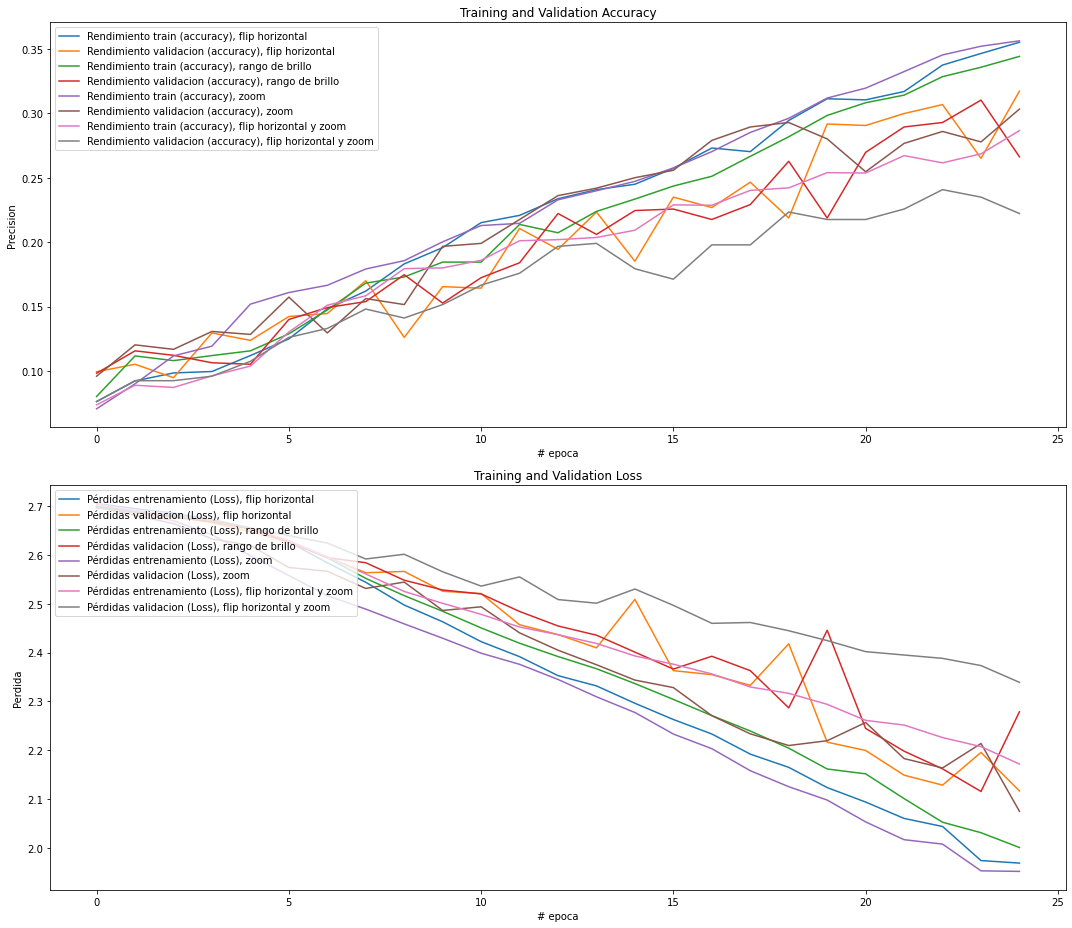

In [ ]:
fig = plt.figure(figsize=(15,13))

plt.subplot(2, 1, 1)
plt.plot(range(EPOCHS), accs[0], label='Rendimiento train (accuracy), flip horizontal')
plt.plot(range(EPOCHS), val_accs[0], label='Rendimiento validacion (accuracy), flip horizontal')
plt.plot(range(EPOCHS), accs[1], label='Rendimiento train (accuracy), rango de brillo')
plt.plot(range(EPOCHS), val_accs[1], label='Rendimiento validacion (accuracy), rango de brillo')
plt.plot(range(EPOCHS), accs[2], label='Rendimiento train (accuracy), zoom')
plt.plot(range(EPOCHS), val_accs[2], label='Rendimiento validacion (accuracy), zoom')
plt.plot(range(EPOCHS), accs[3], label='Rendimiento train (accuracy), flip horizontal y zoom')
plt.plot(range(EPOCHS), val_accs[3], label='Rendimiento validacion (accuracy), flip horizontal y zoom')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')
plt.xlabel('# epoca')
plt.ylabel('Precision')
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.plot(range(EPOCHS), losses[0], label='Pérdidas entrenamiento (Loss), flip horizontal')
plt.plot(range(EPOCHS), val_losses[0], label='Pérdidas validacion (Loss), flip horizontal')
plt.plot(range(EPOCHS), losses[1], label='Pérdidas entrenamiento (Loss), rango de brillo')
plt.plot(range(EPOCHS), val_losses[1], label='Pérdidas validacion (Loss), rango de brillo')
plt.plot(range(EPOCHS), losses[2], label='Pérdidas entrenamiento (Loss), zoom')
plt.plot(range(EPOCHS), val_losses[2], label='Pérdidas validacion (Loss), zoom')
plt.plot(range(EPOCHS), losses[3], label='Pérdidas entrenamiento (Loss), flip horizontal y zoom')
plt.plot(range(EPOCHS), val_losses[3], label='Pérdidas validacion (Loss), flip horizontal y zoom')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.xlabel('# epoca')
plt.ylabel('Perdida')
plt.tight_layout()


plt.show()

#Mostramos las gráficas flip horizontal, ya que es el valor que mejores resultados ha sacado

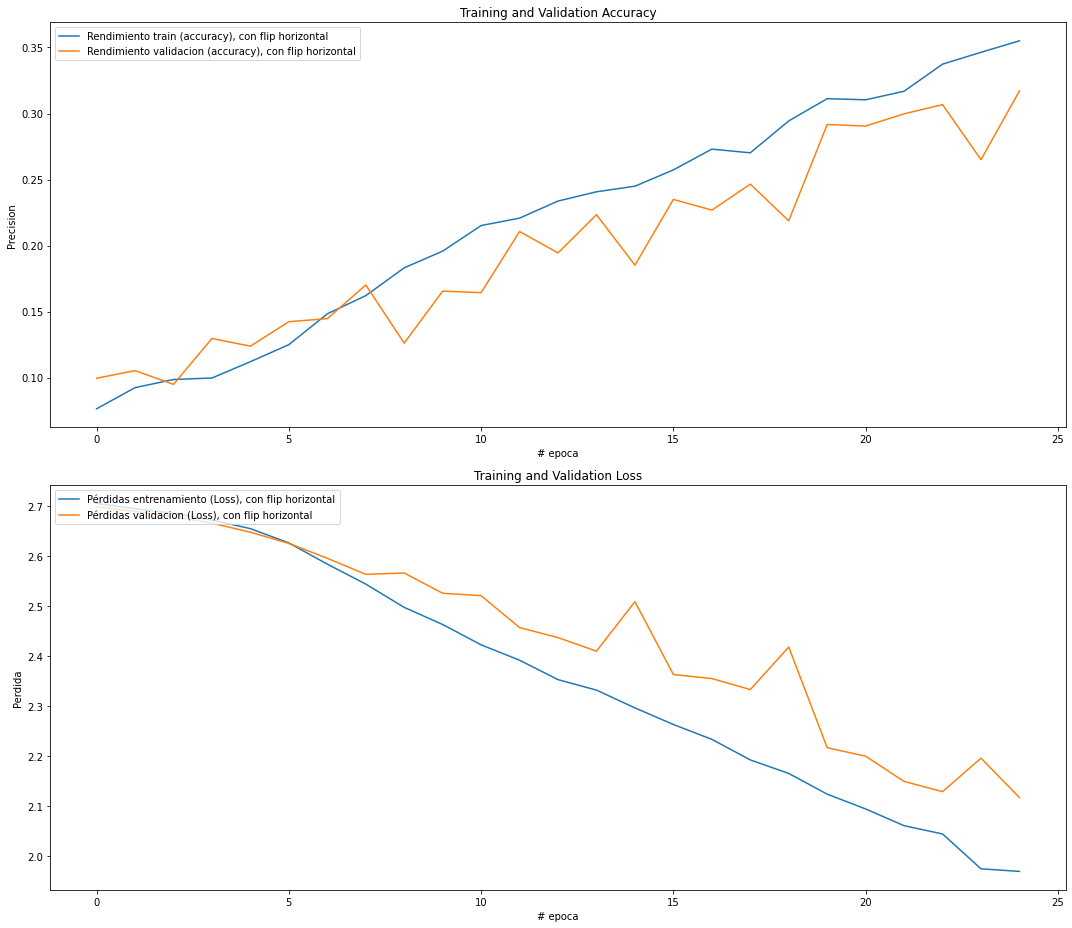

In [ ]:
fig = plt.figure(figsize=(15,13))

plt.subplot(2, 1, 1)
plt.plot(range(EPOCHS), accs[0], label='Rendimiento train (accuracy), con flip horizontal')
plt.plot(range(EPOCHS), val_accs[0], label='Rendimiento validacion (accuracy), con flip horizontal')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')
plt.xlabel('# epoca')
plt.ylabel('Precision')
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.plot(range(EPOCHS), losses[0], label='Pérdidas entrenamiento (Loss), con flip horizontal')
plt.plot(range(EPOCHS), val_losses[0], label='Pérdidas validacion (Loss), con flip horizontal')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.xlabel('# epoca')
plt.ylabel('Perdida')
plt.tight_layout()

plt.show()

#6.Guardar resultados

In [ ]:
#guardar el modelo de red obtenido
#https://www.tensorflow.org/api_docs/python/tf/keras/Model
#https://www.tensorflow.org/tutorials/keras/save_and_load
os.chdir(dwld_dir)  
save_dir = dwld_dir + '/my_models'
subprocess.call(["mkdir","-p",save_dir])  # crear directorio para guardar modelo
model.save(
    save_dir,
    overwrite=True,
    include_optimizer=True,
)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/dwld_dir/my_models/assets
